In [ ]:
import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt


In [ ]:
def convolution2d(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape


    padding_h = (kernel_h - 1) // 2
    padding_w = (kernel_w - 1) // 2

    padded_image = np.pad(image, ((padding_h, padding_h), (padding_w, padding_w)), mode='constant', constant_values=0)
    output = np.zeros((image_h, image_w))

    print(output.size)

    for i in range(image_h):
        for j in range(image_w):
            new = padded_image[i:i+kernel_h, j:j+kernel_w]
            output[i, j] = np.sum(new * kernel)
    return output

image = np.random.rand(8, 4)
print(image)
kernel = np.random.rand(3, 3)
kernel = np.flipud(np.fliplr(kernel))

convolution2d(image,kernel)


[[0.15732629 0.61268274 0.14615    0.22660716]
 [0.25869883 0.46955753 0.1171389  0.44406555]
 [0.46716219 0.16372021 0.93813416 0.91465293]
 [0.07879303 0.66933523 0.80987996 0.08128713]
 [0.71368074 0.75670111 0.17191526 0.25466064]
 [0.58678824 0.72518546 0.62166664 0.33822399]
 [0.81172379 0.09778313 0.17076208 0.5300113 ]
 [0.22321054 0.53610429 0.41620201 0.73945046]]
32


array([[0.94623699, 1.11559242, 1.44219021, 0.54423524],
       [1.14554323, 1.82766166, 2.11603252, 1.49228617],
       [1.12470879, 2.323     , 2.72426519, 2.30691035],
       [1.47772073, 2.63790457, 2.73933608, 1.62200133],
       [2.03085546, 2.92901178, 2.42419639, 1.12360946],
       [1.94980052, 2.78286481, 2.19276048, 1.28587536],
       [1.5354613 , 2.21707997, 2.07604941, 1.37987655],
       [0.93565385, 1.28173656, 1.74405339, 1.17617656]])

155694
155694


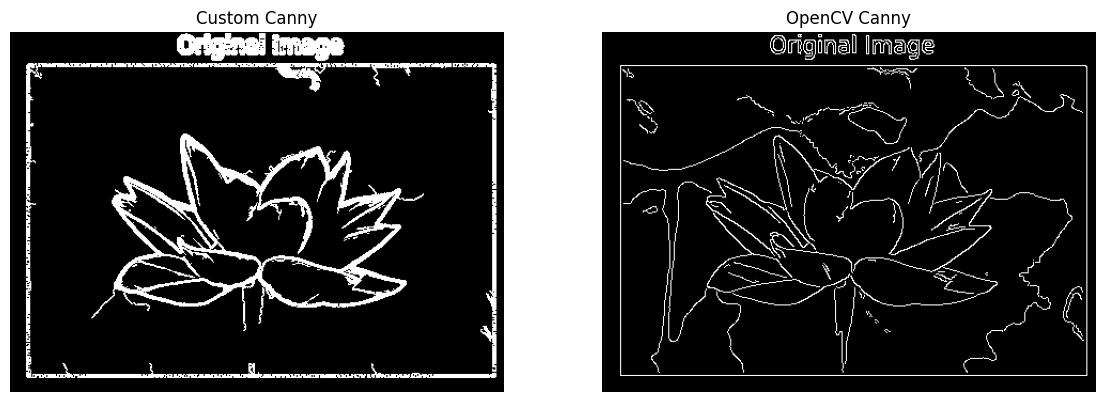

In [ ]:
def canny_edge_detection(image, low=50, high=150):
    # Step 1: blurring

    # step 2: edges
    # sobel used for both blurring and edge detection
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    canny_gx = convolution2d(image.astype(np.float32), sobel_x)
    canny_gy = convolution2d(image.astype(np.float32), sobel_y)
    #finding magnitude
    combined_canny = np.sqrt(canny_gx**2 + canny_gy**2)



    # arctan2 always gives angle in range of -180 to 180 degrees so no need to check for angles higher than 180 here
    angle = np.arctan2(canny_gy, canny_gx)
    angle[angle < 0] += np.pi

    # Step 3: Non-maximum suppression
    nms_r = nms(combined_canny, angle)

    # Step 4: Hysteresis thresholding
    edges = hysteresis(nms_r, low, high)

    return edges

def nms(combined_canny, angle):
    height, width = combined_canny.shape
    suppressed = np.zeros((height, width), dtype=np.float64)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            current_magnitude = combined_canny[i, j]
            current_angle = angle[i, j]

            # Use edge direction (perpendicular to gradient): add pi/2
            edge_angle = current_angle + np.pi / 2
            if edge_angle > np.pi:
                edge_angle -= np.pi
            #dx and dy are the offsets to check the neighboring pixels in the edge direction
            #dx gives the unit step in x direction and dy gives the unit step in y direction
            dx = int(np.cos(edge_angle))
            dy = int(np.sin(edge_angle))

            # Coordinates of the two neighboring pixels in the edge direction
            # one step ahead and one step behind along the axis of the edge

            x1 = j + dx   # one step ahead in x direction from current pixel
            y1 = i + dy   # one step ahead in y direction from current pixel
            x2 = j - dx   # one step behind in x direction from current pixel
            y2 = i - dy  # one step behind in y direction from current pixel

            # Check if the neighboring pixels are within image bounds
            if (0 <= x1 < width and 0 <= y1 < height and
                0 <= x2 < width and 0 <= y2 < height):

                # calculate the magnitudes of the neighboring pixels
                neighbor1_mag = combined_canny[y1, x1]
                neighbor2_mag = combined_canny[y2, x2]

                # Suppress if current pixel is not greater than both neighbors
                if (current_magnitude >= neighbor1_mag and
                    current_magnitude >= neighbor2_mag):
                    suppressed[i, j] = current_magnitude
    return suppressed

def hysteresis(nms_r, low, high):
    """Hysteresis thresholding with weak edges promoted to high threshold value"""
    height, width = nms_r.shape

    strong_edges = (nms_r >= high)
    weak_edges = ((nms_r >= low) & (nms_r < high))

    edges = np.zeros((height, width), dtype=np.uint8)
    edges[strong_edges] = high

    changed = True
    iterations = 0
    while changed and iterations < 10:
        changed = False
        iterations += 1

        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if weak_edges[i, j] and edges[i, j] == 0:
                    neighborhood = edges[i-1:i+2, j-1:j+2]
                    if np.any(neighborhood >= high):  # check connected to "strong"
                        edges[i, j] = high
                        changed = True
    return edges



img = cv2.imread('/content/phool.png', cv2.IMREAD_GRAYSCALE)

# Custom Canny
edges_custom = canny_edge_detection(img, low=50, high=255)

# OpenCV Canny
edges_cv = cv2.Canny(img, 50, 100)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(edges_custom, cmap='gray')
plt.title('Custom Canny')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(edges_cv, cmap='gray')
plt.title('OpenCV Canny')
plt.axis('off')
plt.show()

code with interpolation

The integer version  implemented above rounds the edge direction to the nearest horizontal, vertical, or diagonal pixel, which makes the algorithm simpler but less accurate, since many true edge directions lie between these fixed angles. This often produces thicker or denser edges because suppression is not perfectly aligned with the gradient. The interpolation version instead follows the exact gradient direction by sampling magnitudes at fractional coordinates using bilinear interpolation, which estimates values between real pixels. This makes edge thinning more precise and produces smoother, cleaner edges that closely match the results of OpenCV’s Canny detector.

155694
155694


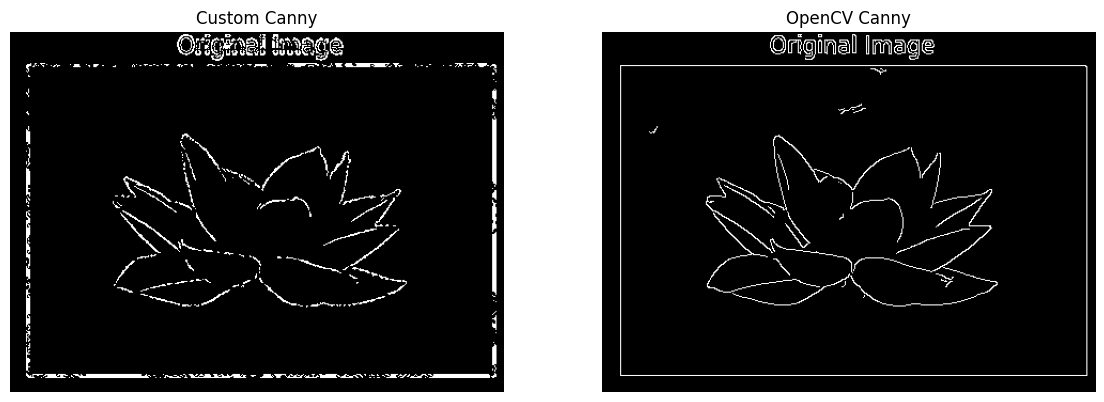

In [ ]:
# code with interpolation

def bilinear_interpolate(img, y, x):

    h, w = img.shape
    if x < 0 or x >= w - 1 or y < 0 or y >= h - 1:
        return 0

    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = x1 + 1, y1 + 1
    fx, fy = x - x1, y - y1

    return (img[y1, x1] * (1 - fx) * (1 - fy) +
            img[y1, x2] * fx * (1 - fy) +
            img[y2, x1] * (1 - fx) * fy +
            img[y2, x2] * fx * fy)


def non_max_suppression(magnitude, angle):
    """Thin edges using gradient direction + interpolation"""
    h, w = magnitude.shape
    suppressed = np.zeros((h, w), dtype=np.float32)

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            mag = magnitude[i, j]
            if mag == 0:
                continue

            edge_angle = angle[i, j] + np.pi / 2
            dx, dy = np.cos(edge_angle), np.sin(edge_angle)

            # Interpolated magnitudes in both directions
            mag1 = bilinear_interpolate(magnitude, i + dy, j + dx)
            mag2 = bilinear_interpolate(magnitude, i - dy, j - dx)

            if mag >= mag1 and mag >= mag2:
                suppressed[i, j] = mag

    return suppressed


def hysteresis(nms, low, high):
    """Hysteresis thresholding"""
    h, w = nms.shape
    strong = (nms >= high)
    weak = ((nms >= low) & (nms < high))

    edges = np.zeros((h, w), dtype=np.uint8)
    edges[strong] = 255

    changed = True
    while changed:
        changed = False
        for i in range(1, h - 1):
            for j in range(1, w - 1):
                if weak[i, j] and edges[i, j] == 0:
                    if np.any(edges[i-1:i+2, j-1:j+2] == 255):
                        edges[i, j] = 255
                        changed = True
    return edges


def custom_canny(image, low=50, high=150):


    # Step 2: Gradient calculation
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

    gx = convolution2d(image.astype(np.float32), sobel_x)
    gy = convolution2d(image.astype(np.float32), sobel_y)

    magnitude = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx)
    angle[angle < 0] += np.pi

    # Step 3: Non-maximum suppression
    nms = non_max_suppression(magnitude, angle)

    # Step 4: Hysteresis
    edges = hysteresis(nms, low, high)
    return edges


img = cv2.imread("/content/phool.png", cv2.IMREAD_GRAYSCALE)

edges_custom = custom_canny(img, low=100, high=150)
edges_cv = cv2.Canny(img, 100, 150)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(edges_custom, cmap="gray")
plt.title("Custom Canny"); plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges_cv, cmap="gray")
plt.title("OpenCV Canny"); plt.axis("off")

plt.show()